#### Importing libraries and data

In [24]:
pip install nasdaq-data-link

Note: you may need to restart the kernel to use updated packages.


In [28]:
import quandl
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [56]:
nasdaqdatalink.ApiConfig.api_key = 'TauEpDkCwzzDQpsss94Q'
df = nasdaqdatalink.get_table(datatable_code='ZILLOW/DATA', api_key = 'TauEpDkCwzzDQpsss94Q')

In [58]:
df.head(100)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2025-01-31,457847.242831
1,ZSFH,99999,2024-12-31,457250.597887
2,ZSFH,99999,2024-11-30,456891.816779
3,ZSFH,99999,2024-10-31,456998.542716
4,ZSFH,99999,2024-09-30,456517.913569
...,...,...,...,...
95,ZSFH,99999,2017-02-28,258373.461313
96,ZSFH,99999,2017-01-31,258619.313531
97,ZSFH,99999,2016-12-31,258430.482695


In [60]:
df.shape

(10000, 4)

In [62]:
df.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [64]:
# Aggregating data based on monthly average
df['date'] = pd.to_datetime(df['date'])

# Group the data by month and calculate the mean of 'value' for each month
df_grouped = df.groupby(df['date'].dt.to_period('M')).agg({'value': 'mean'}).reset_index()

# Convert the 'date' column back to datetime (ensure it's not a PeriodIndex)
df_grouped['date'] = df_grouped['date'].dt.to_timestamp()

# Set 'date' as the index of the dataframe
df_grouped.set_index('date', inplace=True)

In [66]:
print(df_grouped)

                    value
date                     
1996-01-01  142168.833333
1996-02-01  142608.500000
1996-03-01  142872.333333
1996-04-01  143335.333333
1996-05-01  144060.500000
...                   ...
2024-10-01  446222.414617
2024-11-01  446849.874525
2024-12-01  447390.451185
2025-01-01  447428.834210
2025-02-01  284914.814637

[350 rows x 1 columns]


In [68]:
# Setting frequency to month start/month end
df_grouped = df_grouped.asfreq('MS')

In [70]:
# Check for missing values (you shouldn't have any)

df_grouped.isnull()

,value
date,
1996-01-01,False
1996-02-01,False
1996-03-01,False
1996-04-01,False
1996-05-01,False
...,...
2024-10-01,False
2024-11-01,False
2024-12-01,False


In [72]:
df_grouped = df_grouped.dropna()

In [76]:
df_grouped.isnull()

,value
date,
1996-01-01,False
1996-02-01,False
1996-03-01,False
1996-04-01,False
1996-05-01,False
...,...
2024-10-01,False
2024-11-01,False
2024-12-01,False


## Decomposing the Data’s Components

In [80]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_grouped, model='additive')

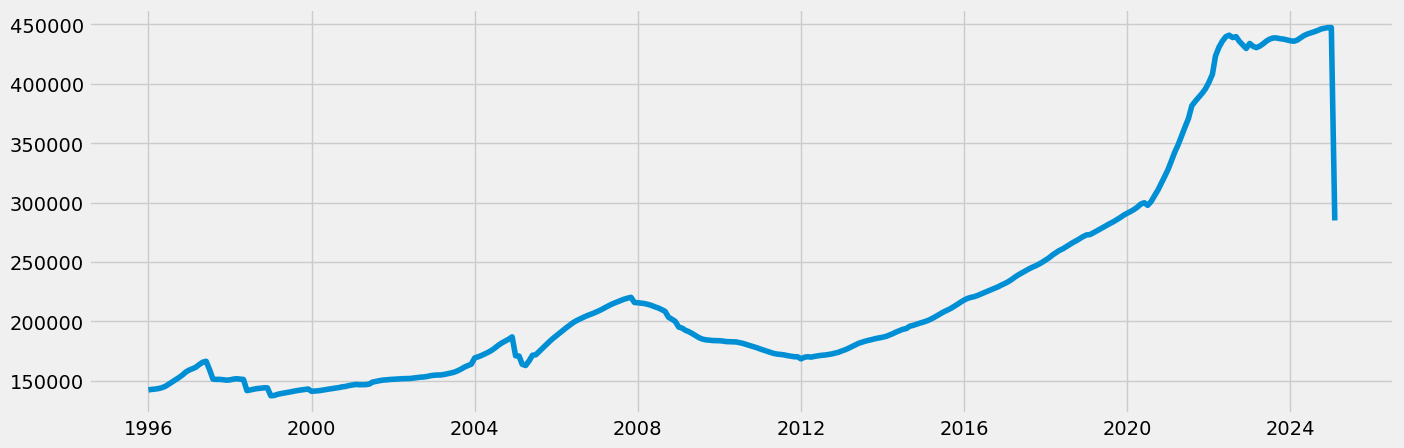

In [82]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_grouped)

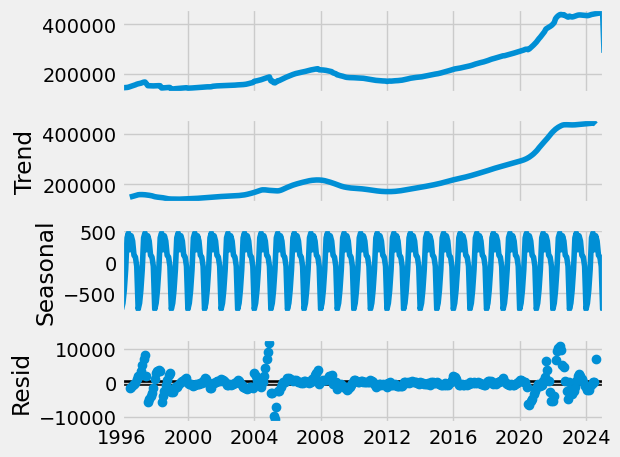

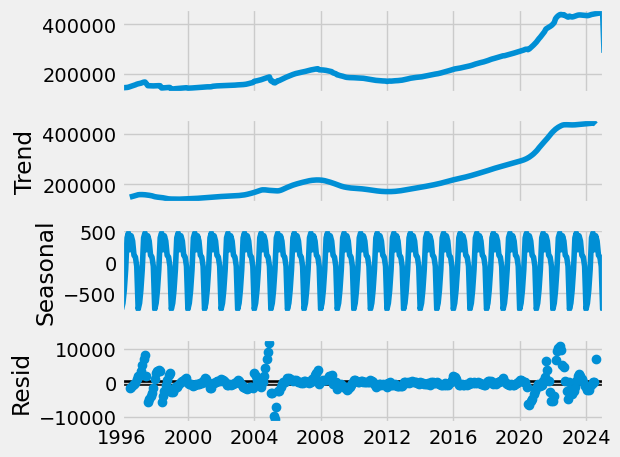

In [84]:
decomposition.plot()

In [109]:
# Trend: showing upward movement
# Seasonality: a pattern that repeats itself periodically at the same time each year
# Residual: showing some noise during 1996, 2004 and 2020

## Conduct a Dickey-Fuller test to check for stationarity

In [90]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [94]:
# Apply the test using the function on the time series
dickey_fuller(df_grouped['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.408460
p-value                          0.139363
Number of Lags Used              2.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


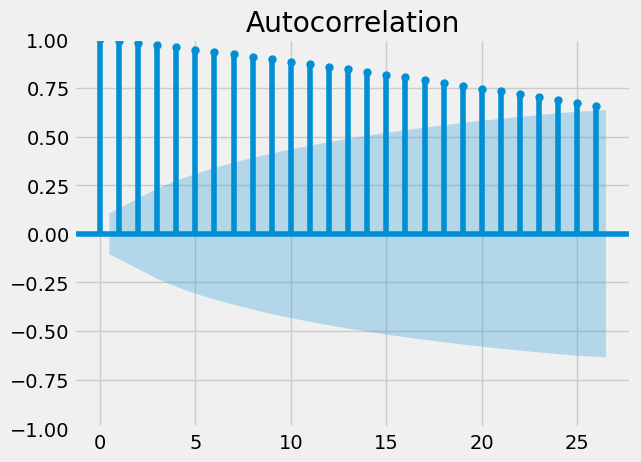

In [96]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_grouped)
plt.show()

In [111]:
# non stationary

In [98]:
data_diff = df_grouped - df_grouped.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [100]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

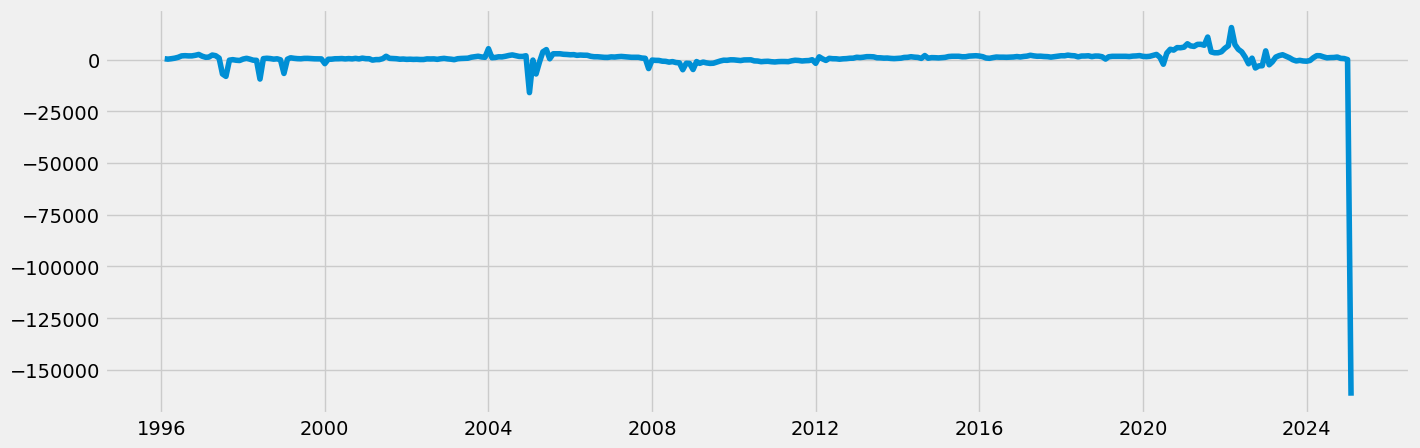

In [102]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [104]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.778665
p-value                          0.391104
Number of Lags Used              0.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


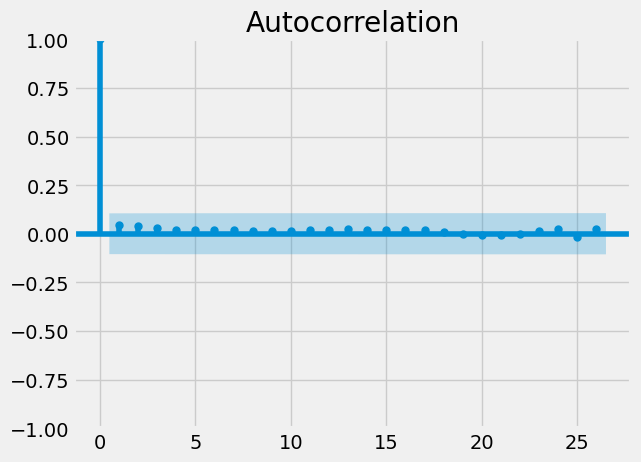

In [106]:
plot_acf(data_diff)
plt.show()